# Projet OpenTopas
## Nicolas Drouin, Xavier Arata, Safarou Nandja

Une partie du code pour la création des figures et le calcul des valeurs demandées est celui de l'année précedente. Nous avons par contre pris soin de remplacer l'analyse par notre propre analyse.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate
from matplotlib.patches import Rectangle
from scipy.stats import linregress
from scipy.interpolate import make_interp_spline
import seaborn as sns


In [4]:
# Fonction servant à convertir les fichiers de simulations csv en numpy (même fonction que l'année précédente).
'''
def csv_to_np(name, sub_directory, skip_num=8, start_col=2):
    """Fonction pour transformer les fichiers csv en numpy array 2d.
    Par défaut, seul les 3 dernières colonnes sont conservées (numéro du bin, dose (Gy), écart-type (Gy)).
    name: nom en string du fichier csv.
    skip_num: nombre de rangées au début du fichier à passer (dans l'header). Par défaut = 8.
    start_col: numéro de la première colonne à conserver, par défaut = 2 pour conserver les 3 dernières seulement.
    """
    
    #data = pd.read_csv("/Users/frederiquelarose/Desktop/Cours_Automne_2023/Physique_des_radiations/Devoir_Topas/Resultats_6.9/"+name,sep=',', header=None, skiprows=skip_num).to_numpy()[:,start_col:]
    data = pd.read_csv("Données/" + sub_directory + "/"+name,sep=',', header=None, skiprows=skip_num).to_numpy()[:,start_col:]
    return data'''

def csv_to_np(name, sub_directory):
    """Lit un fichier TOPAS et retourne les colonnes Z, Dose, Std."""
    data = pd.read_csv(f"{sub_directory}/{name}", 
                comment="#",
                header=None, 
                names=["X","Y","Z","Dose","StdDev"]).to_numpy()

    # garde Z, Dose, Std (les 3 dernières colonnes)
    return data[:, -3:]


# Constantes

MeV_to_joule = 1.602176565e-13 # J/MeV
rho_eau = 0.9982 # g/cm3
Rcsda = np.array([4.367e-1, 0.9783, 2.35, 4.975, 9.32, 13.17, 16.65, 19.83])




# Figure 6.6

1 MeV - Erreur relative suffisante atteinte!
0.00425 % < 3 %
2 MeV - Erreur relative suffisante atteinte!
0.00179 % < 3 %
5 MeV - Erreur relative suffisante atteinte!
0.000994 % < 3 %
10 MeV - Erreur relative suffisante atteinte!
0.000491 % < 3 %
20 MeV - Erreur relative suffisante atteinte!
0.000336 % < 3 %
30 MeV - Erreur relative suffisante atteinte!
0.000156 % < 3 %
40 MeV - Erreur relative suffisante atteinte!
0.000177 % < 3 %
50 MeV - Erreur relative suffisante atteinte!
0.000119 % < 3 %


C:\Users\nicdr\AppData\Local\Temp\ipykernel_21300\3409963357.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R50[i] = freduced2.roots()
C:\Users\nicdr\AppData\Local\Temp\ipykernel_21300\3409963357.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R50[i] = freduced2.roots()
C:\Users\nicdr\AppData\Local\Temp\ipykernel_21300\3409963357.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  R50[i] = freduced2.roots()
C:\Users\nicdr\AppData\Local\Temp\ipykernel_21

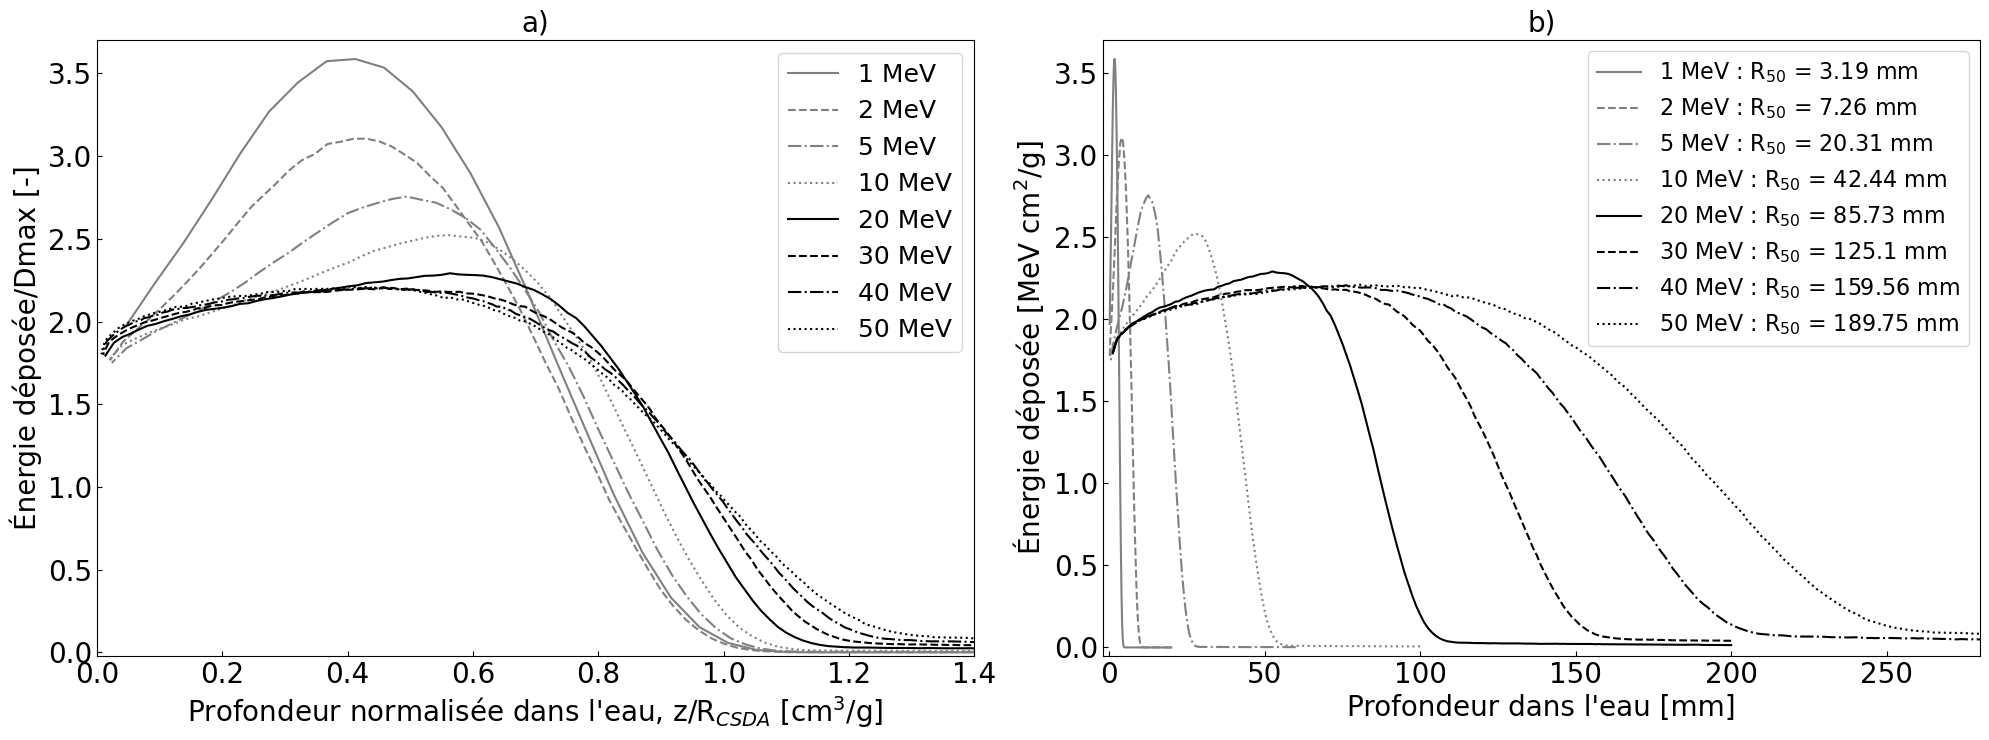

Les rapports de la dose à la surface sur la dose maximale pour 1, 2, 5, 10, 20, 30, 40 et 50 MeV sont respectivement: [54.96 56.83 63.51 70.41 78.29 81.63 81.6  81.56] %


In [9]:
""" Le code ci-bas génère la figure 6.6 du manuel de référence, soit la superposition des courbes
    de distribution de dose pour des faisceaus d'électrons de différente énergie (1-50 MeV) dans un fantôme d'eau."""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. 
Les portés Rcsda ne sont pas utilisées directement dans les codes TOPAS, mais le paramètre
HLZ du scorer est réglé pour que sa profondeur totale soit plus grande que la portée Rcsda en cm."""

field_size = 100 # cm2
energies = np.array([1, 2, 5, 10, 20, 30, 40, 50])
Rcsda = np.array([4.367e-1, 0.9783, 2.55, 4.975, 9.32, 13.17, 16.65, 19.83]) # g/cm2
Rcsda_cm = Rcsda/rho_eau # cm
el_nbr = np.array([20000000, 20000000, 20000000, 20000000, 20000000, 20000000, 20000000, 20000000]) # nbr d'électrons simulés pour chaque énergie
bin_nbr = np.array([100, 100, 100, 100, 160, 160, 240, 240]) # nbr de bins pour chaque énergie
tot_depths = np.array([2, 2, 6, 10, 20, 20, 30, 30]) # profondeur des scorers pour chaque énergie, cm
in_fluence = el_nbr/field_size # cm-2

np.seterr(divide='ignore', invalid='ignore')

# initialisation des matrices de données
data=np.empty((np.size(energies),np.max(bin_nbr),3))
std_rel = np.empty(np.size(energies))
R50 = np.empty(np.size(energies))
Dmax = np.empty(np.size(energies))
Dsurf = np.empty(np.size(energies))


# initialisation des figures

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7.5))  

ax1.set_xlabel("Profondeur normalisée dans l'eau, z/R$_{CSDA}$ [cm$^3$/g]", fontsize='20')
ax1.set_ylabel("Énergie déposée/Dmax [-]", fontsize='20')
ax1.set_title("a)", fontsize='20')
ax1.tick_params(direction='in', labelsize='20')

ax2.set_xlabel("Profondeur dans l'eau [mm]", fontsize='20')
ax2.set_ylabel("Énergie déposée [MeV cm$^2$/g]", fontsize='20')
ax2.set_title("b)", fontsize='20')
ax2.tick_params(direction='in', labelsize='20')

marker = ['-','--','-.',':','k-','k--','k-.','k:']

# ------------------------------- Fonctions de calcul ------------------------------------------- #
for i in range(len(energies)):
    e = np.array2string(energies[i])
    name = '6.6_{}MeV.csv'.format(e)
    data[i][:bin_nbr[i],:] = csv_to_np(name, "Figure_6_6") # extraction des données csv en numpy array
    bins = data[i][:bin_nbr[i],0]
    dose = data[i][:bin_nbr[i],1]
    std = data[i][:bin_nbr[i],2]

    # vecteurs de profondeur
    depth = (bin_nbr[i]-bins)*(tot_depths[i]/bin_nbr[i]) # cm, défini à partir des numéros de bins et de la profondeur totale du scorer
    depth_norm = depth/Rcsda[i] # cm

    
    # erreur relative
    std_rel[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel[i] < 3: # erreur maximale est choisie à 3%
        print(energies[i], "MeV - Erreur relative suffisante atteinte!")
        print(format(std_rel[i], '.3g'), "% <", "3 %")
    else:
        print(energies[i], "MeV - Erreur relative trop élevée")
        print(format(std_rel[i], '.3g'), "% >", "3 %")

    # conversion dose
    dose_norm = dose/(1000*MeV_to_joule*in_fluence[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # Dmax
    """ Calcul de Dmax à l'aide d'une inteprolation sur la courbe de dose soustraite par la dose maximale"""
    dose_max = np.max(dose_norm)
    freduced1 = interpolate.UnivariateSpline(np.flip(depth*10), np.flip((dose_norm-dose_max)), s=0)
    Dmax[i] = np.mean(freduced1.roots())

    # R50
    """ Calcul de R50 à l'aide d'une inteprolation sur la courbe de dose soustraite par la dose à 50%"""
    dose_50 = 0.5*dose_max
    freduced2 = interpolate.UnivariateSpline(np.flip(depth*10), np.flip((dose_norm-dose_50)), s=0)
    R50[i] = freduced2.roots()

    # Dose à la surface
    """ Calcul du rapport de la dose à la surface sur la dose maximale"""
    Dsurf[i] = 100*dose_norm[-1]/dose_max

    if energies[i] < 11:
        # figure 6.6a)
        ax1.plot(depth_norm, dose_norm, marker[i], label = "{} MeV".format(e), color="grey")
        # figure 6.6b)
        ax2.plot(depth*10, dose_norm, marker[i], label = "{} MeV : R$_{{50}}$ = {} mm".format(e,round(R50[i],2)), color="grey")
    else:
        # figure 6.6a)
        ax1.plot(depth_norm, dose_norm, marker[i], label = "{} MeV".format(e))
        # figure 6.6b)
        ax2.plot(depth*10, dose_norm, marker[i], label = "{} MeV : R$_{{50}}$ = {} mm".format(e,round(R50[i],2)))

ax1.set_xlim([0, 1.4])
ax1.set_ylim([-0.02, 3.7])
ax2.set_xlim([-2, 280])
ax2.set_ylim([-0.05, 3.7])
ax1.legend(loc=0, frameon=True, fontsize='18')
ax2.legend(loc=0, frameon=True, fontsize='16')
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

print("Les rapports de la dose à la surface sur la dose maximale pour 1, 2, 5, 10, 20, 30, 40 et 50 MeV sont respectivement:",np.round(Dsurf,2),"%")




## Analyse de la figure 6.6

Comportement des faisceaux à la surface : La dose à la surface augmente plus rapidement pour les faisceaux de basse énergie que ceux de haute énergie. En effet, les électrons plus énergétiques ont un plus grand pouvoir pénétrant, ce qui explique pourquoi les faisceaux de plus hautes énergie déposen leur énergie plus loin dans le milieu.

Build up du faisceau : La figure 6.6 montre bien le phénomène de build-up du faisceau d'électrons. On remarque que plus l'énergie du faisceau est basse, plus la montée vers la dose maximale est accentuée. Ce comportement est expliqué par le fait que les électrons de plus faible énergie ont une plus grande probabilité de subir une diffusion élastique. Ces diffusions altèrent la direction des électrons (direction qui au départ était parallèle au faisceau), ce qui augmente la quantité d'énergie déposée à une profondeur donnée.

Après le build up : Le build up du faisceau mène à la profondeur où on retrouve un maximum d'énergie déposée. Après ce maximum, on a une descente abrupte de l'énergie déposée en fonction de la profondeur dû au fait que les électrons ont dépensé la majorité de leur énergie dans le début du milieu. On marque par contre toujours une déposition d'énergie à des profondeurs plus grandes aque le $R_{CSDA}$. La queue présente sur les graphiques est la queue Bremmstrahlung et est plus significative pour les faisceaux d'électrons à plus haute énergie puisque le pouvoir d'arrêt radiatif di milieu augmente avec l'énergie des électrons incidents.



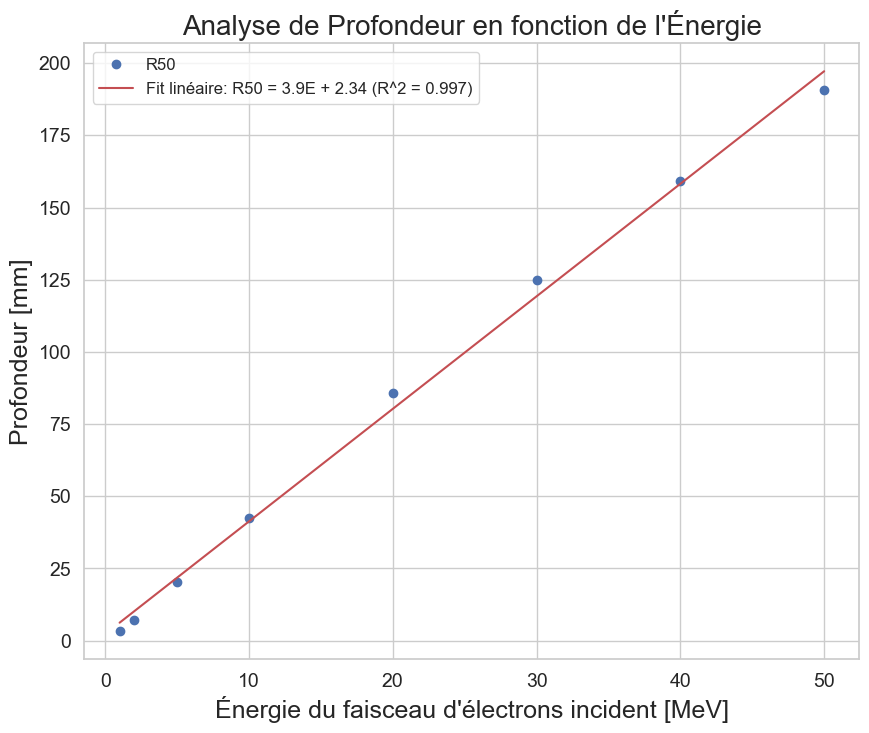

In [83]:

# Set the seaborn style for better aesthetics
sns.set(style="whitegrid")

# Compute linear fits
fit_dmax = linregress(energies, Dmax)
fit_R50 = linregress(energies, R50)



# Generate the x-values for plotting the fit lines
x_dmax = np.linspace(1, 50, 100)
y_dmax = fit_dmax.slope * x_dmax + fit_dmax.intercept

x_R50 = np.linspace(1, 50, 100)
y_R50 = fit_R50.slope * x_R50 + fit_R50.intercept

# Create the figure and axis objects
fig2, ax1 = plt.subplots(figsize=(10, 8))

# Plot the actual data points
ax1.plot(energies, R50, 'bo', label="R50")  # Blue circles for R50
# ax1.plot(energies, Dmax, 'rs', label="Dmax")  # Red squares for Dmax

# Use spline interpolation for Dmax
spline = make_interp_spline(energies, Dmax, k=3)
x_Dmax_smooth = np.linspace(min(energies), max(energies), 300)
y_Dmax_smooth = spline(x_Dmax_smooth)


# Plot the linear fit lines
ax1.plot(x_R50, y_R50, 'r-', label=f"Fit linéaire: R50 = {round(fit_R50.slope,2)}E + {round(fit_R50.intercept,2)} (R^2 = {round(fit_R50.rvalue**2,3)})")
# ax1.plot(x_dmax, y_dmax, 'b-', label=f"Fit linéaire: Dmax = {round(fit_dmax.slope,2)}E + {round(fit_dmax.intercept,2)} (R^2 = {round(fit_dmax.rvalue**2,3)})")
# ax1.plot(x_Dmax_smooth, y_Dmax_smooth, 'g--', label="Smoothed_Dmax")  
# Annotating points of maximum R50 and Dmax
max_R50 = np.max(R50)
max_Dmax = np.max(Dmax)
max_R50_energy = energies[np.argmax(R50)]
max_Dmax_energy = x_Dmax_smooth[np.argmax(y_Dmax_smooth)]


# Setting the labels and title
ax1.set_xlabel("Énergie du faisceau d'électrons incident [MeV]", fontsize=18)
ax1.set_ylabel("Profondeur [mm]", fontsize=18)
ax1.set_title("Analyse de Profondeur en fonction de l'Énergie", fontsize=20)

# Customizing the tick parameters
ax1.tick_params(axis='both', which='major', labelsize=14)

# Adding the legend with a frame
ax1.legend(loc='upper left', frameon=True, fontsize=12)

plt.show()




On observe une relation linéaire entre l'énergie incidente des électrons et la valeur de R50 ($R^2 = 0.997$). Le manuel FIORD présente une relation semi-empirique (équation 7.17) entre l'énergie moyenne à la surface et R50:

$\bar{E}_0(\text{MeV}) = CR_{50}$ 

avec $C = 2.33 \text{ MeV cm}^{-1}$. À partir de notre interpolation linéaire, on a:

\begin{gather}
R_{50}[\text{cm}] \approx 3.9 [\frac{\text{cm}}{\text{MeV}}]\bar{E}_0[\text{MeV}]\\
\bar{E}_0 [\text{MeV}]\approx 0.26[\frac{\text{MeV}}{\text{cm}}] R_{50}[\text{cm}]\\
\bar{E}_0[\text{MeV}] \approx 2.6 [\frac{\text{MeV}}{\text{mm}}] R_{50}[\text{mm}]
\end{gather}

# Figure 6.9

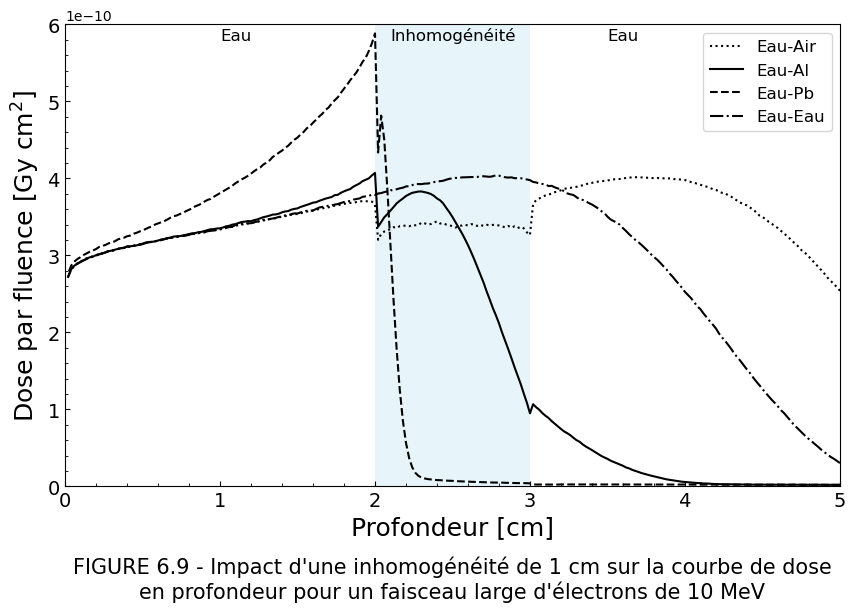

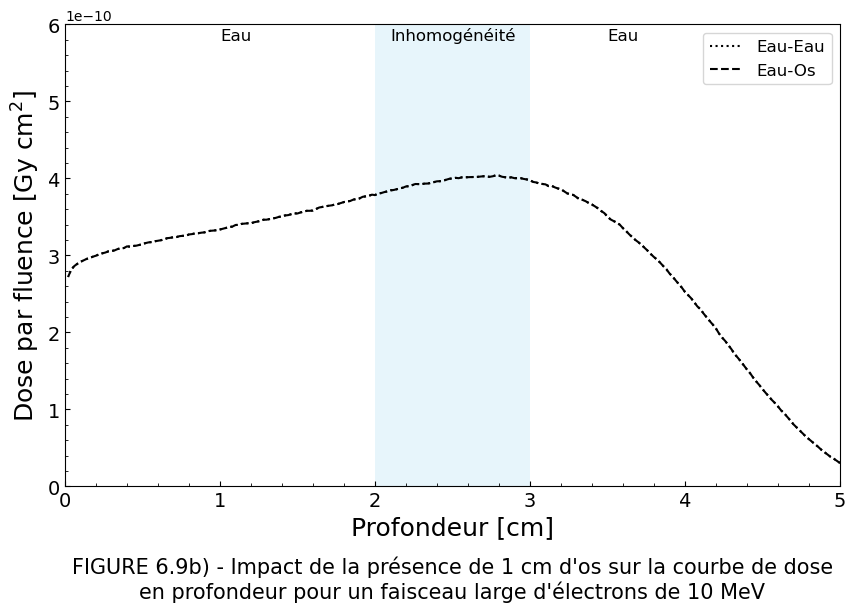

In [ ]:
""" Le code ci-bas génère la figure 6.9 du manuel de référence, soit la superposition des courbesù
    de distribution de dose pour un faisceau d'électrons de 10MeV dans un fantôme d'eau contenant
    une inhomogénéité de 1cm de large de nature définie. La simulation est effectuée
    en utilisant 10^8 histoires."""

# ------------------------------- Paramètres ------------------------------------------- #
field_size = 100 # cm2
energy = 10 # MeV

el_nbr = 5e7 # nbr d'électrons simulés pour chaque inhomogénéité
el_nbr_air = 1e8
bin_nbr = 250 # nbr de bins utilisé
materials = ["Air", "Al", "Pb", "Eau"] # inhomogénéités considérées
tot_depth = 5 # profondeur du scorer, cm
in_fluence = el_nbr/field_size # fluence simulée, cm-2
in_fluence_air = el_nbr_air/field_size # fluence simulée, cm-2

# initialisation des matrices de données
data=np.empty([np.size(materials),bin_nbr,3])
std_rel = np.empty(np.size(materials))

# initialisation des figures
fig1 = plt.figure(figsize=(10, 6))
ax1 = plt.subplot(1, 1, 1)
plt.xlabel("Profondeur [cm]", fontsize='18')
plt.ylabel("Dose par fluence [Gy cm$^2$]", fontsize='18')

marker = ['k:','k','k--','k-.']

# ------------------------------- Fonctions de calcul ------------------------------------------- #

for i in range(len(materials)):
    material = materials[i]
    n_hist = '100M' if material == 'Air' else '50M'
    name = f"Fig_6_9_{material}_{n_hist}.csv"
    data_i = csv_to_np(name, "Figure_6_9")

    nrows = min(bin_nbr, data_i.shape[0])
    data[i, :nrows, :] = data_i[:nrows, :]

    bins = data_i[:nrows, 0]   # Z
    dose = data_i[:nrows, 1]   # Dose
    std  = data_i[:nrows, 2]   # Std

    depth = (bin_nbr - bins) * (tot_depth / bin_nbr)
    std_rel[i] = (np.mean(std / dose)) * 100

    dose_norm = dose / (in_fluence_air if material == 'Air' else in_fluence)
    ax1.plot(depth, dose_norm, marker[i], label=f"Eau-{material}")




# ------------------------------- Affichage final des résultats ------------------------------------------- #

ax1.set_xlim([0, 5])
ax1.set_ylim([0, 6e-10])
ax1.legend(loc=0, frameon=True, fontsize='12')
ax1.minorticks_on()

ax1.add_patch( Rectangle((2, -1e-10),
                        1, 8e-10,
                        fc ='skyblue',alpha = 0.2,
                        lw = 0) )
plt.annotate('Eau', (1, 5.8e-10), fontsize=12, color='k')
plt.annotate('Inhomogénéité', (2.1, 5.8e-10), fontsize=12, color='k')
plt.annotate('Eau', (3.5, 5.8e-10), fontsize=12, color='k')
plt.tick_params(which='both',direction='in',labelsize='14')
plt.text(
    0.5, -0.2,
    "FIGURE 6.9 - Impact d'une inhomogénéité de 1 cm sur la courbe de dose\n"
    "en profondeur pour un faisceau large d'électrons de 10 MeV",
    fontsize=15, ha='center', va='center',
    transform=plt.gca().transAxes
)
plt.savefig('Figure_6_9/Figure_6_9.png', bbox_inches='tight')


# ------------------------------- Pour pousser plus loin ------------------------------------------- #

"""
Material: G4_BONE_COMPACT_ICRU
Density: 1.85 g/cm3

Elemental composition (by mass fraction):
H  0.064
C  0.278
N  0.027
O  0.410
Mg 0.002
P  0.070
S  0.002
Ca 0.147
"""
data=np.empty([np.size(materials),bin_nbr,3])
std_rel = np.empty(np.size(materials))
fig2 = plt.figure(figsize=(10, 6))
ax2 = plt.subplot(1, 1, 1)
plt.xlabel("Profondeur [cm]", fontsize='18')
plt.ylabel("Dose par fluence [Gy cm$^2$]", fontsize='18')
plt.title("",  fontsize='20')

marker = ['k:','k--']
materials = ['Eau', 'Os']

for i in range(len(materials)):
    material = materials[i]
    name = f"Fig_6_9_{material}_50M.csv"
    data_i = csv_to_np(name, "Figure_6_9")

    nrows = min(bin_nbr, data_i.shape[0])
    data[i, :nrows, :] = data_i[:nrows, :]

    bins = data_i[:nrows, 0]   # Z
    dose = data_i[:nrows, 1]   # Dose
    std  = data_i[:nrows, 2]   # Std

    depth = (bin_nbr - bins) * (tot_depth / bin_nbr)
    std_rel[i] = (np.mean(std / dose)) * 100

    dose_norm = dose / (in_fluence_air if material == 'Air' else in_fluence)
    ax2.plot(depth, dose_norm, marker[i], label=f"Eau-{material}")


ax2.set_xlim([0, 5])
ax2.set_ylim([0, 6e-10])
ax2.legend(loc=0, frameon=True, fontsize='12')
ax2.minorticks_on()
ax2.add_patch( Rectangle((2, -1e-10),
                        1, 8e-10,
                        fc ='skyblue',alpha = 0.2,
                        lw = 0) )
plt.annotate('Eau', (1, 5.8e-10), fontsize=12, color='k')
plt.annotate('Inhomogénéité', (2.1, 5.8e-10), fontsize=12, color='k')
plt.annotate('Eau', (3.5, 5.8e-10), fontsize=12, color='k')
plt.tick_params(which='both',direction='in',labelsize='14')
plt.text(
    0.5, -0.2,
    "FIGURE 6.9b) - Impact de la présence de 1 cm d'os sur la courbe de dose\n"
    "en profondeur pour un faisceau large d'électrons de 10 MeV",
    fontsize=15, ha='center', va='center',
    transform=plt.gca().transAxes
)
plt.savefig('Figure_6_9/Figure_6_9_b.png', bbox_inches='tight')





## Analyse de la figure 6.9

Lors que le faisceau primaire d'électrons rentre en contact avec l'inhomogénéité, une certaine partie des électrons est back-scattered, ce qui contribue (avec le build up du faisceau discutée précedemment) à l'augmentation de l'énergie déposée en fonction de la profondeur avant l'inhomogénéité. Plus l'inhomogénéité à un numbre atomique $Z$ élevé, plus le back-scattering est élevé, ce qui explique pourquoi l'énergie déposée la plus élevée avant l'inhomogénéité est avec l'interface de plomb, puis d'aluminium, puis d'eau et finalement d'air. 

Dans tous les cas sauf celui sans inhomogénéité, l'énergie déposée voit une diminution rapide à l'entrée de l'interface. 

À l'intérieur de l'inhomogénéité, les faisceaux se propageant maintenant dans l'aluminium et le plomb montrent encore une fois un build up du faisceau (le build up est plus difficile à discerner pour le plomb). Après ce build up, l'énergie déposée diminue graduellement à l'intérieur de l'interface. Avant la fin de l'inhomogénéité, toujours pour les interfaces de plomb et d'aluminium, on voit une petite diminution de l'énergie déposée expliquée par la diminution du back-scattering avec le milieu après l'inhomogénéité, milieu qui a un $Z$ plus faible.

Pour le faisceau se propageant dans l'inhomogénéité d'air, la faible pouvoir d'arrêt de l'air explique la constance de l'énergie qui y est déposée. On s'attend à voir une faible augmentation de l'énergie déposée vers la fin de l'inhomogénéité causée par le back-scattering avec l'eau après l'inhomogénéité (à cause du Z plus élevé).

# Spectre


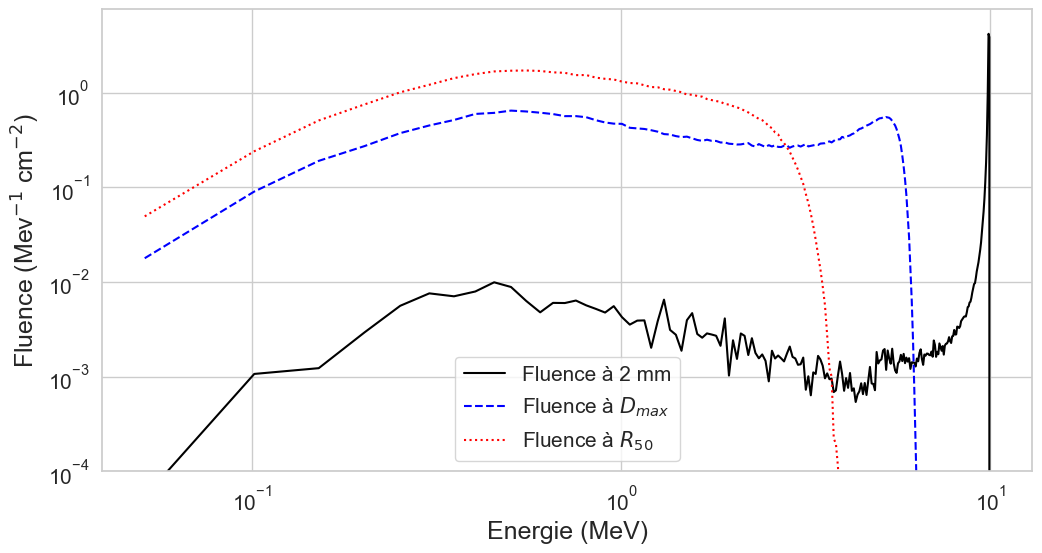

In [40]:
file1 = 'Données/Fluence/Fluence_primaire.csv' 
file2 = 'Données/Fluence/Fluence_Secondaire.csv'

data1 = np.loadtxt(file1, delimiter=',', skiprows=12)
data2 = np.loadtxt(file2, delimiter=',', skiprows=12)

#La longeur du scorer est 80mm
#Scorer bin à 2mm de la surface  
Entrance = 78 #80-2

#Scorer bin à la dose maximale
Dmax = 53 #80-27

#Scorer bin à la moitié de la dose
R50 = 38 #80-42
Emin,Emax=0.001,10.001
Energy_bins=200
Energy = np.linspace(Emin,Emax,Energy_bins)

Primary_fluence_entrance = data1[Entrance,:200]/Energy/100
Primary_fluence_Dmax = data1[Dmax,:200]/Energy/100
Primary_fluence_R50 = data1[R50,:200]/Energy/100

fig = plt.figure(figsize=(12,6))

plt.plot(Energy[1:], Primary_fluence_entrance[1:],c="black",label = "Fluence à 2 mm")
plt.plot(Energy[1:], Primary_fluence_Dmax[1:], linestyle='--' ,c='blue', label = "Fluence à $D_{max}$")
plt.plot(Energy[1:], Primary_fluence_R50[1:], linestyle='dotted', c='red', label = "Fluence à $R_{50}$")

plt.xlabel(r'Energie (MeV)', fontsize=18)
plt.ylabel(r'Fluence (Mev$^{-1}$ cm$^{-2}$)', fontsize=18)
plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-4,)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)

plt.show()

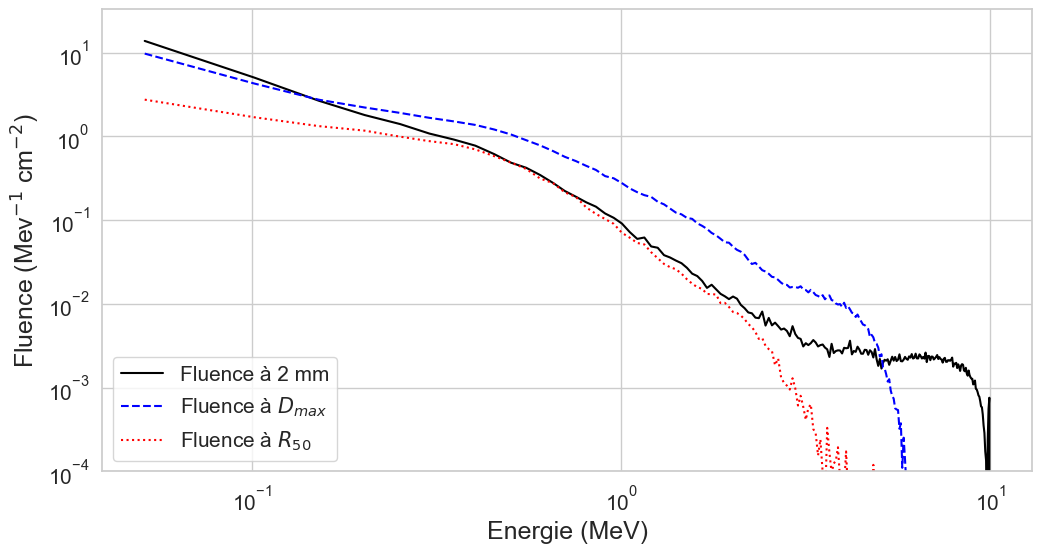

In [ ]:
Secondary_fluence_entrance = data2[Entrance,:200]/Energy/100
Secondary_fluence_Dmax = data2[Dmax,:200]/Energy/100
Secondary_fluence_R50 = data2[R50,:200]/Energy/100

fig = plt.figure(figsize=(12,6))

plt.plot(Energy[1:], Secondary_fluence_entrance[1:],c="black",label = "Fluence à 2 mm")
plt.plot(Energy[1:], Secondary_fluence_Dmax[1:], linestyle='--' ,c='blue', label = "Fluence à $D_{max}$")
plt.plot(Energy[1:], Secondary_fluence_R50[1:], linestyle='dotted', c='red', label = "Fluence à $R_{50}$")

plt.xlabel(r'Energie (MeV)', fontsize=18)
plt.ylabel(r'Fluence (Mev$^{-1}$ cm$^{-2}$)', fontsize=18)

plt.xscale("log")
plt.yscale("log")
plt.ylim(1e-4,)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.legend(fontsize=15,loc="lower left")

plt.show()



# Bonus Figure 6.8


In [ ]:
""" Le code ci-bas génère une figure afin d'évaluer l'effet des interactions d'électrons simulées sur la
    distribution de dose pour un faisceau d'électrons d'énergie 10 MeV dans un fantôme d'eau."""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. 
Les portés Rcsda ne sont pas utilisées directement dans les codes TOPAS, mais le paramètre
HLZ du scorer est réglé pour que sa profondeur totale soit plus grande que la portée Rcsda en cm."""

# Constantes
MeV_to_joule = 1.602176565e-13 # J/MeV
rho_eau = 0.9982 # g/cm3
Rcsda = 4.975 # g/cm^2


field_size = 100 # cm2
energie = 10 # MeV
en_J = energie*MeV_to_joule # J
Rcsda_cm = Rcsda/rho_eau # cm

results = ['6.8_10MeV.csv', '6.8_10MeV_SS.csv', '6.8_10MeV_nobrem.csv', '6.8_10MeV_brem.csv']
sims = ['full', 'SS', 'Sans bremsstrahlung', 'Seulement bremsstrahlung']

el_nbr = np.array([20000000, 1000000, 20000000, 20000000])
bin_nbr = 80
tot_depth = 10 # cm

in_fluence = el_nbr/field_size #cm^-2

np.seterr(divide='ignore', invalid='ignore')


# initialisation des matrices de données
data=np.empty((np.size(results),bin_nbr,3))
std_rel = np.empty(np.size(results))

d= csv_to_np(results[2], "Figure_6_8", skip_num=10)
d_norm = d[:, 1]/(1000*MeV_to_joule*in_fluence[2])

d_red = d_norm*Rcsda/energie



Simulation full - Erreur relative suffisante atteinte!
0.000879 % < 3 %
Simulation SS - Erreur relative suffisante atteinte!
0.0169 % < 3 %
Simulation Sans bremsstrahlung - Erreur relative suffisante atteinte!
0.000999 % < 3 %
Simulation Seulement bremsstrahlung - Erreur relative suffisante atteinte!
0.00535 % < 3 %


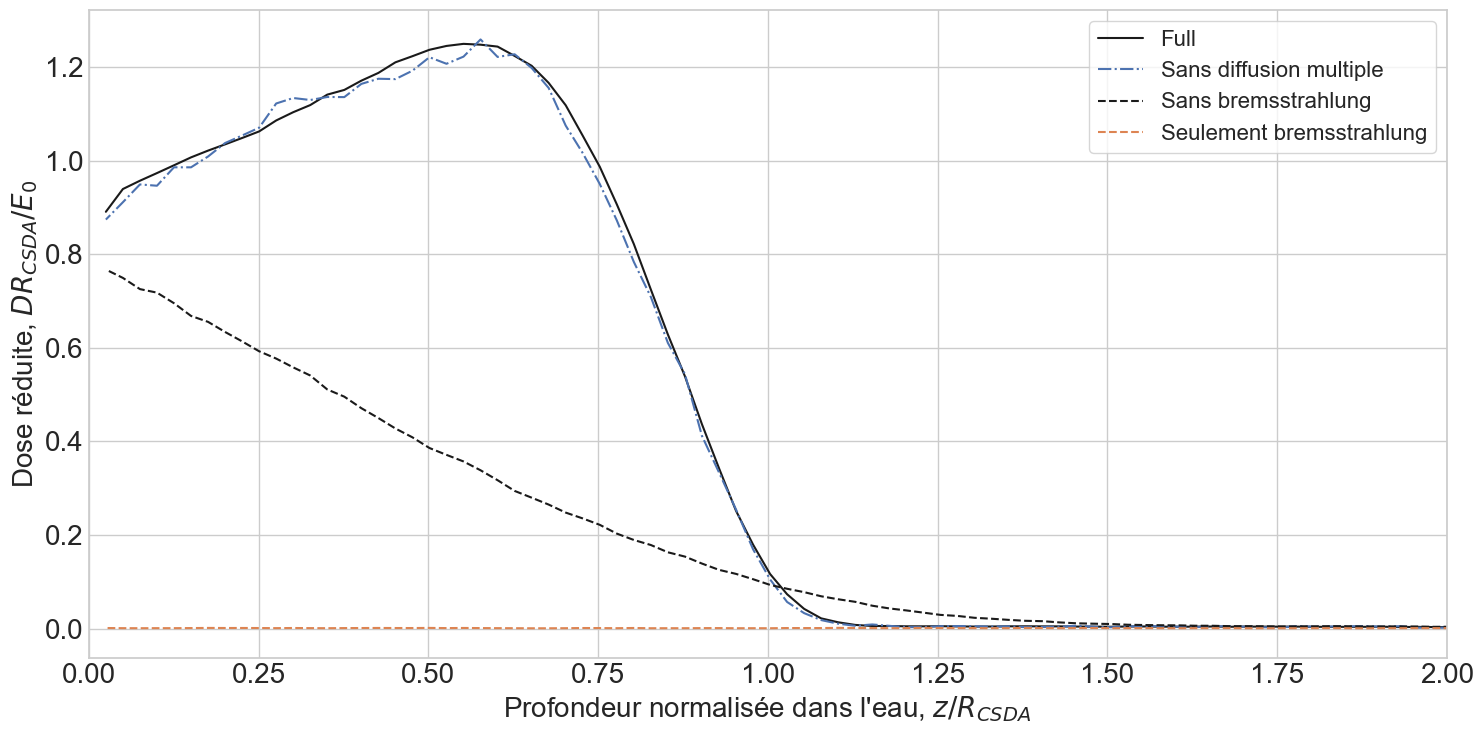

In [78]:
# initialisation des figures

fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))  

ax.set_xlabel("Profondeur normalisée dans l'eau, $z/R_{CSDA}$ ", fontsize='20')
ax.set_ylabel("Dose réduite, $DR_{CSDA}/E_0$", fontsize='20')
ax.set_title("", fontsize='20')
ax.tick_params(direction='in', labelsize='20')

marker = ['k-','-.','k--','--']
labels = ['Full', 'Sans diffusion multiple', 'Sans bremsstrahlung', 'Seulement bremsstrahlung']

for i in range(len(results)):
    if i <= 1:
        data[i][:bin_nbr,:] = csv_to_np(results[i], "Figure_6_8") # extraction des données csv en numpy array

    else:
        data[i][:bin_nbr,:] = csv_to_np(results[i], "Figure_6_8", skip_num=9) # extraction des données csv en numpy array

    bins = data[i][:bin_nbr,0]
    dose = data[i][:bin_nbr,1]
    std = data[i][:bin_nbr,2]

    dose_norm = dose/(1000*MeV_to_joule*in_fluence[i]) # MeV cm2/g, conversion des MeV en Joule et normalisation par la fluence initiale

    # vecteurs de profondeur
    depth = (bin_nbr-bins)*(tot_depth/bin_nbr) # cm, défini à partir des numéros de bins et de la profondeur totale du scorer
    depth_norm = depth/Rcsda_cm # cm

    dose_red = dose_norm*Rcsda/energie

    ax.plot(depth_norm, dose_red, marker[i], label = labels[i])

    # erreur relative
    std_rel[i] = (np.nanmean(std/dose))*100 # % erreur moyenne sur mesure de dose
    if std_rel[i] < 3: # erreur maximale est choisie à 3%
        print("Simulation", sims[i], "- Erreur relative suffisante atteinte!")
        print(format(std_rel[i], '.3g'), "% <", "3 %")
    else:
        print("Simulation", sims[i], "- Erreur relative trop élevée")
        print(format(std_rel[i], '.3g'), "% >", "3 %")


ax.set_xlim([0, 2])
ax.legend(loc=0, frameon=True, fontsize='16')
ax.tick_params(direction='in', labelsize='20')

plt.grid(True)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping

# plt.savefig("/Users/mohammedobaid/Desktop/fig1.jpg",dpi=600,bbox_inches="tight")

plt.show()

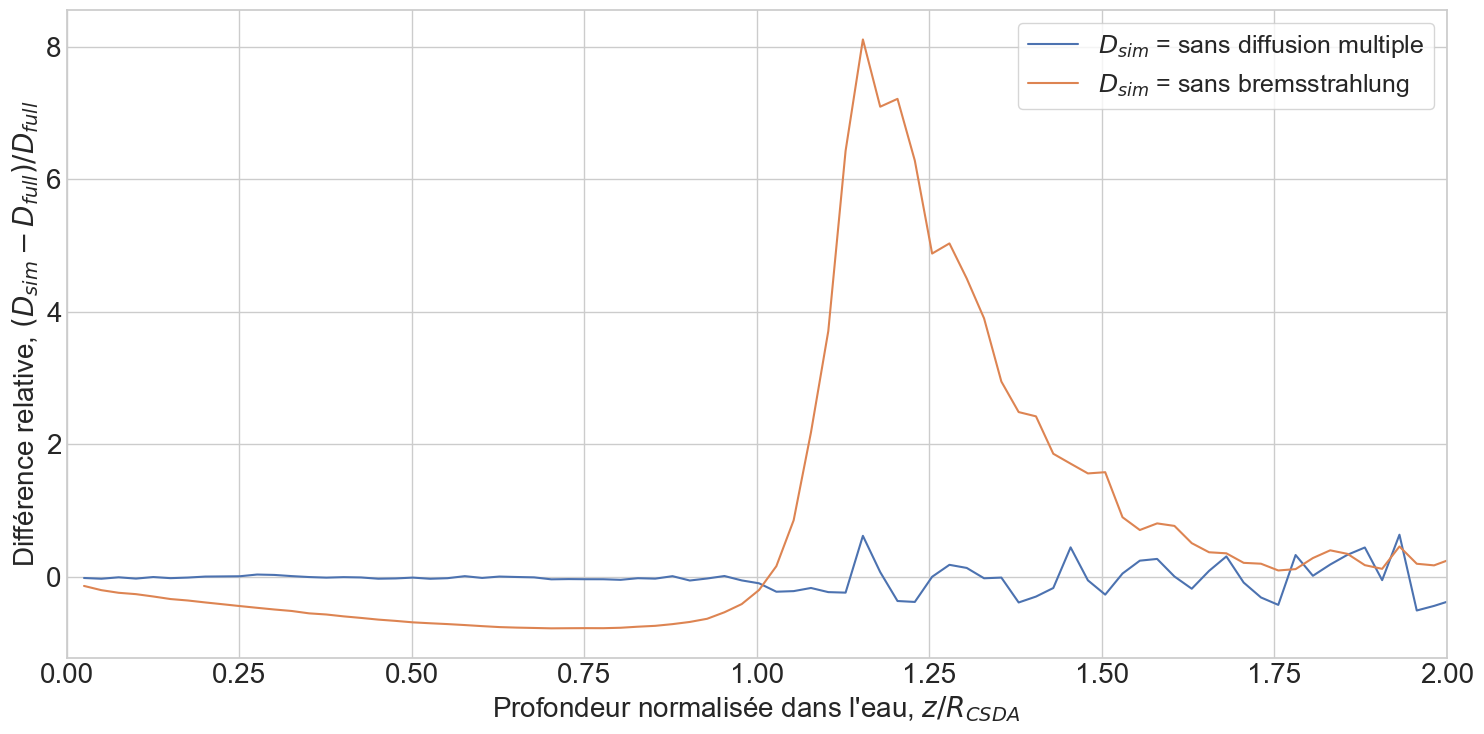

In [79]:
# Calculer la différence relative de la dose sans multiple scattering par rapport à la dose full

bins = data[0][:bin_nbr,0]


dose_full = data[0][:bin_nbr,1]
dose_full_norm = dose_full/(1000*MeV_to_joule*in_fluence[0])
dose_full_red = dose_full_norm*Rcsda/energie

dose_SS = data[1][:bin_nbr,1]
dose_SS_norm = dose_SS/(1000*MeV_to_joule*in_fluence[1])
dose_SS_red = dose_SS_norm*Rcsda/energie

dose_no_brem = data[2][:bin_nbr,1]
dose_no_brem_norm = dose_no_brem/(1000*MeV_to_joule*in_fluence[2])
dose_no_brem_red = dose_no_brem_norm*Rcsda/energie

difference_SS = (dose_SS_red - dose_full_red)/dose_full_red

difference_no_brem = (dose_no_brem_red - dose_full_red)/dose_full_red

# vecteurs de profondeur
depth = (bin_nbr-bins)*(tot_depth/bin_nbr) # cm, défini à partir des numéros de bins et de la profondeur totale du scorer
depth_norm = depth/Rcsda_cm # cm


fig, ax = plt.subplots(1, 1, figsize=(15, 7.5))  

labels = ['$D_{sim}$ = sans diffusion multiple', '$D_{sim}$ = sans bremsstrahlung']
ax.plot(depth_norm, difference_SS, label = labels[0])
ax.plot(depth_norm, difference_no_brem, label = labels[1])
ax.set_xlabel("Profondeur normalisée dans l'eau, $z/R_{CSDA}$ ", fontsize='20')
ax.set_ylabel("Différence relative, $(D_{sim} - D_{full})/D_{full}$", fontsize='20')
ax.legend(loc=0, frameon=True, fontsize='18')
ax.set_xlim([0, 2])
ax.tick_params(direction='in', labelsize='20')



plt.grid(True)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
# plt.savefig("/Users/mohammedobaid/Desktop/fig2.jpg",dpi=600,bbox_inches="tight")

plt.show()


In [1]:
## BONUS - Figure 6.4



5 MeV - Erreur relative suffisante (0.000497 % < 3 %)
10 MeV - Erreur relative suffisante (0.000706 % < 3 %)
20 MeV - Erreur relative suffisante (0.000708 % < 3 %)
40 MeV - Erreur relative suffisante (0.000901 % < 3 %)


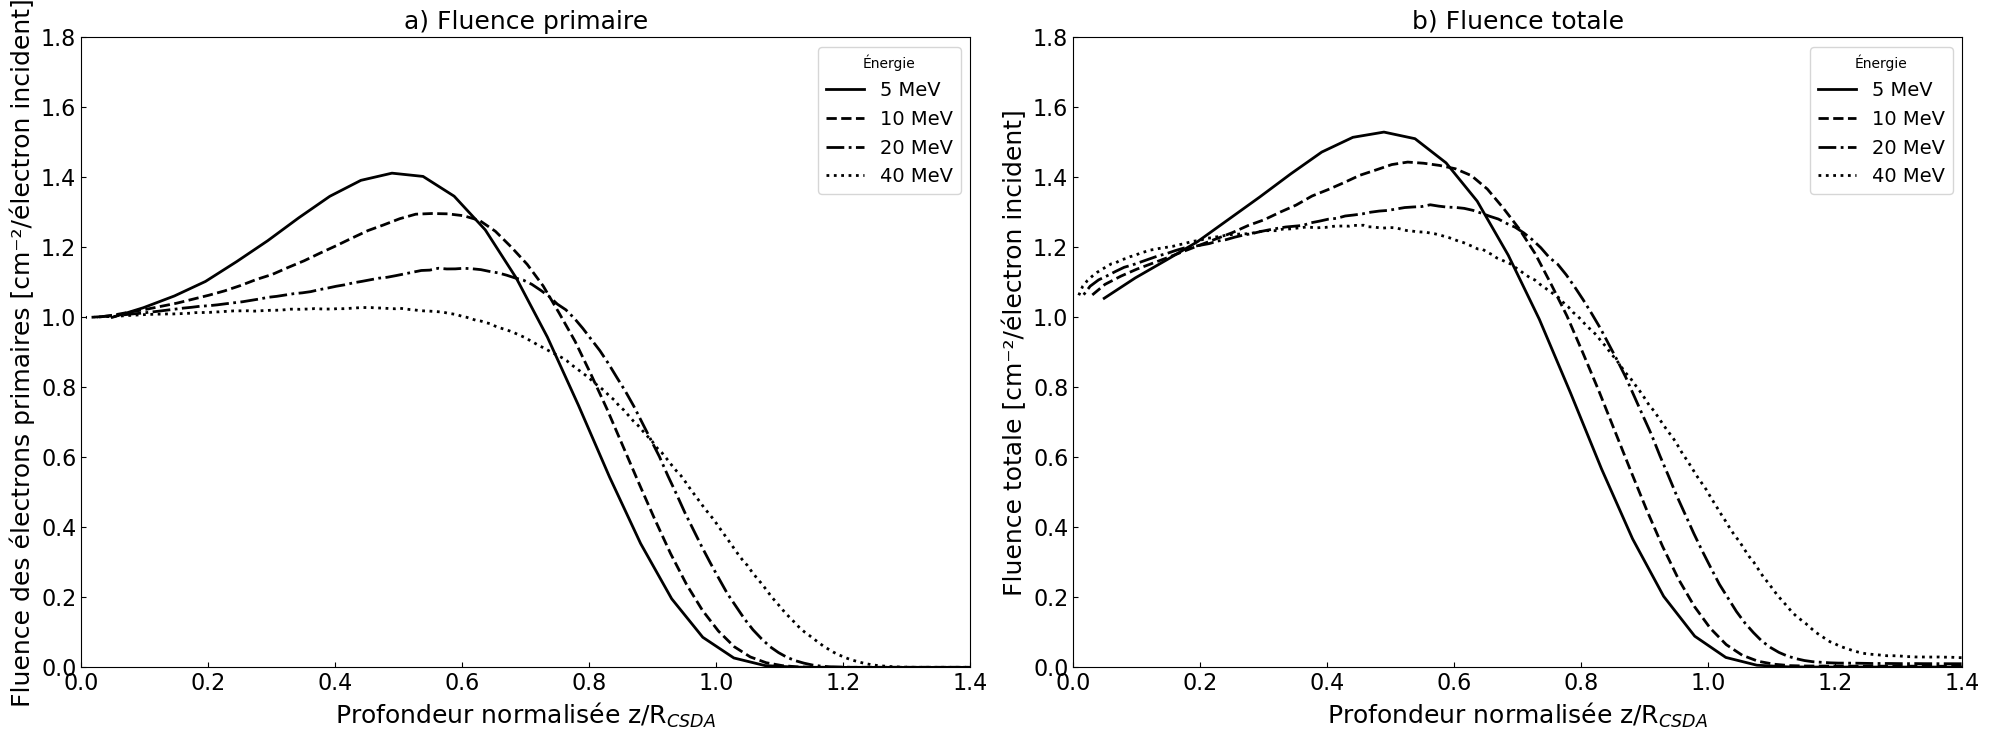

'ax1.set_xlim([0, 1.4])\nax1.set_ylim([-0.02, 3.7])\nax2.set_xlim([-2, 280])\nax2.set_ylim([-0.05, 3.7])\nax1.legend(loc=0, frameon=True, fontsize=\'18\')\nax2.legend(loc=0, frameon=True, fontsize=\'16\')\nplt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping\nplt.show()\n\nprint("Les rapports de la dose à la surface sur la dose maximale pour 1, 2, 5, 10, 20, 30, 40 et 50 MeV sont respectivement:",np.round(Dsurf,2),"%")\n\n'

In [24]:
"""


****************  Copié de 6.6,  à arranger



"""

# ------------------------------- Paramètres ------------------------------------------- #
""" Initialisation des paramètres utilisés dans les codes de simulation TOPAS. 
Les portés Rcsda ne sont pas utilisées directement dans les codes TOPAS, mais le paramètre
HLZ du scorer est réglé pour que sa profondeur totale soit plus grande que la portée Rcsda en cm."""

energies = np.array([5, 10, 20, 40])
Rcsda = np.array([2.55, 4.975, 9.32, 16.65])  # g/cm2
Rcsda_cm = Rcsda / rho_eau  # cm
el_nbr = np.array([2e7, 2e7, 2e7, 2e7])  # nombre d'électrons simulés
bin_nbr = np.array([240, 240, 240, 240])
tot_depths = np.array([30, 30, 30, 30])  # profondeur du scorer, cm
field_size = 100.0  # cm²
in_fluence = el_nbr / field_size  # cm⁻²

np.seterr(divide='ignore', invalid='ignore')

# ------------------------------- Initialisation ------------------------------------------- #
data_primary = np.empty((len(energies), np.max(bin_nbr), 3))
data_total = np.empty((len(energies), np.max(bin_nbr), 3))

std_rel = np.empty(len(energies))


# ------------------------------- Figures ------------------------------------------- #
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7.5))

ax1.set_xlabel("Profondeur normalisée z/R$_{CSDA}$", fontsize=18)
ax1.set_ylabel("Fluence des électrons primaires [cm⁻²/électron incident]", fontsize=18)
ax1.set_title("a) Fluence primaire", fontsize=18)
ax1.tick_params(direction='in', labelsize=16)

ax2.set_xlabel("Profondeur normalisée z/R$_{CSDA}$", fontsize=18)
ax2.set_ylabel("Fluence totale [cm⁻²/électron incident]", fontsize=18)
ax2.set_title("b) Fluence totale", fontsize=18)
ax2.tick_params(direction='in', labelsize=16)

markers = ['k-', 'k--', 'k-.', 'k:']

# ------------------------------- Boucle principale ------------------------------------------- #
for i, E in enumerate(energies):
    prim_data = csv_to_np(f"Fig_6_4_a_{E}MeV.csv", "Figure_6_4/a_primaire")
    tot_data = csv_to_np(f"Fig_6_4_b_{E}MeV.csv", "Figure_6_4/b_total")   #*****************************à changer quand données de b) sont dispo

    n_prim = prim_data.shape[0]
    n_tot = tot_data.shape[0]


    # Lecture des fichiers TOPAS
    data_primary[i, :n_prim, :] = np.pad(prim_data, ((0, np.max(bin_nbr) - n_prim), (0, 0)), mode='constant', constant_values=np.nan)
    data_total[i, :n_tot, :] = np.pad(tot_data, ((0, np.max(bin_nbr) - n_tot), (0, 0)), mode='constant', constant_values=np.nan)


    # Extraction
    z_bins_prim = data_primary[i, :n_prim, 0]
    fluence_prim = data_primary[i, :n_prim, 1]
    std_prim = data_primary[i, :n_prim, 2]

    z_bins_tot = data_total[i, :n_tot, 0]
    fluence_tot = data_total[i, :n_tot, 1]
    std_tot = data_total[i, :n_tot, 2]

    # Conversion en profondeur
    depth = (bin_nbr[i] - z_bins_prim) * (tot_depths[i] / bin_nbr[i])  # cm
    depth_norm = depth / Rcsda_cm[i]

    # Normalisation par électron incident
    fluence_prim_norm = fluence_prim / fluence_prim[-1]
    fluence_tot_norm = fluence_tot / fluence_prim[-1]


    # Erreur relative
    std_rel[i] = np.nanmean(std_prim / fluence_prim) * 100

    if std_rel[i] < 3:
        print(f"{E} MeV - Erreur relative suffisante ({std_rel[i]:.6f} % < 3 %)")
    else:
        print(f"{E} MeV - Erreur relative trop élevée ({std_rel[i]:.6f} % > 3 %)")

    # Tracé
    ax1.plot(depth_norm, fluence_prim_norm, markers[i], linewidth=2, label=f"{E} MeV")
    ax2.plot(depth_norm, fluence_tot_norm, markers[i], linewidth=2, label=f"{E} MeV")

# ------------------------------- Finitions ------------------------------------------- #
ax1.legend(title="Énergie", fontsize=14)
ax2.legend(title="Énergie", fontsize=14)

for ax in (ax1, ax2):
    ax.set_xlim(0, 1.4)
    ax.set_ylim(0, 1.8)
    ax.tick_params(direction='in')

plt.tight_layout()
plt.show()

"""ax1.set_xlim([0, 1.4])
ax1.set_ylim([-0.02, 3.7])
ax2.set_xlim([-2, 280])
ax2.set_ylim([-0.05, 3.7])
ax1.legend(loc=0, frameon=True, fontsize='18')
ax2.legend(loc=0, frameon=True, fontsize='16')
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()

print("Les rapports de la dose à la surface sur la dose maximale pour 1, 2, 5, 10, 20, 30, 40 et 50 MeV sont respectivement:",np.round(Dsurf,2),"%")

"""

## Discussion - Figures Extra


Ces deux figures montrent plusieurs points liés au comportment de la déposition de dose en profondeur dans l'eau: 

**Simulation full**: On remarque que la courbe de dose réduite ressemble à celle de la Figure 6.8a et celle de la Figure 6.6a. Elle montre une montée vers la dose maximale dans la région de build-up, suivie par une chute due à la perte d'énergie des électrons après des diffusions. 

**Simulation bremsstrahlung**: Cette courbe ressemble à celle de la Figure 6.8a, ce qui confirme que les interactions bremsstrahlung contribuent de façon minimale à la déposition de dose, par rapport aux autres interactions. 

**Simulation sans bremsstrahlung**: Cette courbe ne ressemble pas à cella de la Figure 6.8a, ce qui indique que le code TOPAS, avec les paramètres choisis, ne semble pas simuler les mêmes interactions qui se trouvent dans cette figure-là. En particulier, on ne constate pas une région de build-up; au contraire, la dose déposée diminue avec la profondeur. La courbe s'approche de la dose full vers $R_{CSDA}$, et elles se rapprochent à mesure qu'il reste une dose détectable due aux interactions bremsstrahlung aux profondeurs supérieures. 

**Simulation sans diffusion multiple**: Cette courbe montre la déposition de dose lorsque seulement la diffusion élastique est simulée. On remarque des variations autour de la courbe full, en raison du nombre inférieur de particules simulées, ce qui augmentent aux profondeurs supérieures à $R_{CSDA}$, où l'effet de la diffusion multiple est plus prononcé dans la déposition de dose.
